<a href="https://colab.research.google.com/github/cristian0527/MATH-383/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2
### Cristian Castellanos
### Network Data

Since getting a pdf is weird, here is my github repo for this hw assignment for it to look visually appealing!

https://github.com/cristian0527/MATH-383/blob/main/HW2.ipynb

## Load packages

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy.linalg as LA
import matplotlib as mpl
import matplotlib.cm as cm
import math
import requests
import json
from networkx.readwrite import json_graph
import pandas as pd
import csv
from sklearn.cluster import KMeans
from collections import Counter
from scipy.integrate import odeint

## Problem 1
#### Dolphins Network: Opinion Dynamics

In [56]:
# load dolphin network
loaded_matrix = np.loadtxt("./dolphins.csv", delimiter=",")
dolphin_graph_loaded = nx.from_numpy_array(loaded_matrix)

pos = nx.spring_layout(dolphin_graph_loaded, seed=67)

#### Beliefs initially distributed uniformly between the three categories

In [52]:
reds = []
greens = []
blues = []
steps_list = []
consensus_list = []

for trial in range(100):
    # uniform probability between red, green, blue
    for node in dolphin_graph_loaded.nodes():
        x = random.random()
        if x < 0.33:
            dolphin_graph_loaded.nodes[node]['Opinion'] = 'r'
        elif x < 0.66:
            dolphin_graph_loaded.nodes[node]['Opinion'] = 'g'
        else:
            dolphin_graph_loaded.nodes[node]['Opinion'] = 'b'

    # declaring variables for condition (100 steps or until consensus met)
    steps = 0
    consensus = False

    for step in range(100):
        steps += 1

        # node updates based on neighbors' opinions
        for node in dolphin_graph_loaded.nodes():
            neighbor_opinions = []

            for neighbor in dolphin_graph_loaded.neighbors(node):
                neighbor_opinions.append(dolphin_graph_loaded.nodes[neighbor]['Opinion'])

            # count neighbors opinion + total neighbors
            opinion_counts = Counter(neighbor_opinions)
            total_neighbors = len(neighbor_opinions)

            # new opinion proportional to neighbor counts
            rand_val = random.random()
            cumulative_prob = 0

            for opinion, count in opinion_counts.items():
                cumulative_prob += count / total_neighbors
                if rand_val < cumulative_prob:
                    dolphin_graph_loaded.nodes[node]['New_Opinion'] = opinion
                    break

        # update node opinions
        for node in dolphin_graph_loaded.nodes():
            dolphin_graph_loaded.nodes[node]['Opinion'] = dolphin_graph_loaded.nodes[node]['New_Opinion']

        # consensus
        all_opinions = [dolphin_graph_loaded.nodes[node]['Opinion'] for node in dolphin_graph_loaded.nodes()]
        if len(set(all_opinions)) == 1:
            consensus = True
            break

    # count final opinions and append to lists
    red_count = 0
    green_count = 0
    blue_count = 0

    for node in dolphin_graph_loaded.nodes():
        if dolphin_graph_loaded.nodes[node]['Opinion'] == 'r':
            red_count += 1
        elif dolphin_graph_loaded.nodes[node]['Opinion'] == 'g':
            green_count += 1
        else:
            blue_count += 1

    reds.append(red_count)
    greens.append(green_count)
    blues.append(blue_count)
    steps_list.append(steps)
    consensus_list.append(consensus)

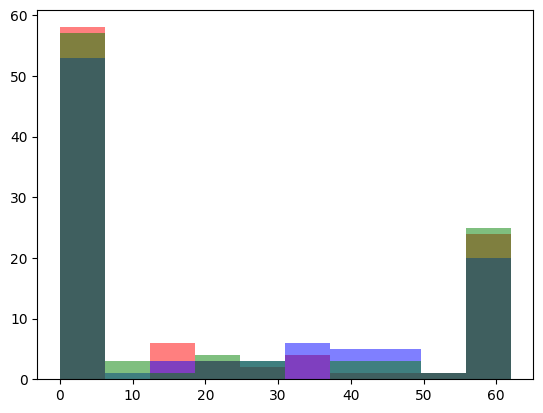

In [129]:
plt.hist(reds,color='r',alpha=.5)
plt.hist(blues,color='b',alpha=.5)
plt.hist(greens,color='g',alpha=.5)
plt.show()

#### Initial distributions where one opinion is twice as likely as the other two, and compare your results.

In [130]:
reds = []
greens = []
blues = []
steps_list = []
consensus_list = []

for trial in range(100):
    # uniform probability between red, green, blue
    for node in dolphin_graph_loaded.nodes():
        x = random.random()
        if x < 0.25:
            dolphin_graph_loaded.nodes[node]['Opinion'] = 'r'
        elif x < 0.50:
            dolphin_graph_loaded.nodes[node]['Opinion'] = 'g'
        else:
            dolphin_graph_loaded.nodes[node]['Opinion'] = 'b'

    # declaring variables for condition (100 steps or until consensus met)
    steps = 0
    consensus = False

    for step in range(100):
        steps += 1

        # node updates based on neighbors' opinions
        for node in dolphin_graph_loaded.nodes():
            neighbor_opinions = []

            for neighbor in dolphin_graph_loaded.neighbors(node):
                neighbor_opinions.append(dolphin_graph_loaded.nodes[neighbor]['Opinion'])

            # count neighbors opinion + total neighbors
            opinion_counts = Counter(neighbor_opinions)
            total_neighbors = len(neighbor_opinions)

            # new opinion proportional to neighbor counts
            rand_val = random.random()
            cumulative_prob = 0

            for opinion, count in opinion_counts.items():
                cumulative_prob += count / total_neighbors
                if rand_val < cumulative_prob:
                    dolphin_graph_loaded.nodes[node]['New_Opinion'] = opinion
                    break

        # update node opinions
        for node in dolphin_graph_loaded.nodes():
            dolphin_graph_loaded.nodes[node]['Opinion'] = dolphin_graph_loaded.nodes[node]['New_Opinion']

        # consensus
        all_opinions = [dolphin_graph_loaded.nodes[node]['Opinion'] for node in dolphin_graph_loaded.nodes()]
        if len(set(all_opinions)) == 1:
            consensus = True
            break

    # count final opinions and append to lists
    red_count = 0
    green_count = 0
    blue_count = 0

    for node in dolphin_graph_loaded.nodes():
        if dolphin_graph_loaded.nodes[node]['Opinion'] == 'r':
            red_count += 1
        elif dolphin_graph_loaded.nodes[node]['Opinion'] == 'g':
            green_count += 1
        else:
            blue_count += 1

    reds.append(red_count)
    greens.append(green_count)
    blues.append(blue_count)
    steps_list.append(steps)
    consensus_list.append(consensus)

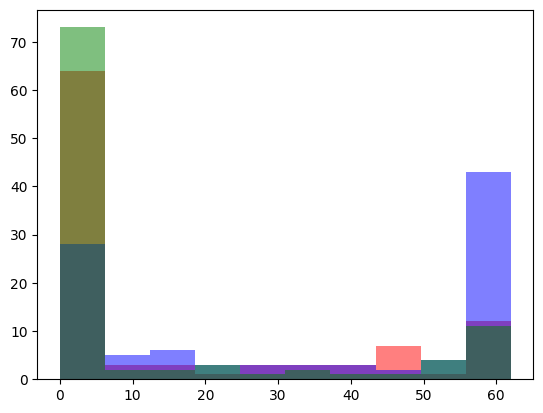

In [131]:
plt.hist(reds,color='r',alpha=.5)
plt.hist(blues,color='b',alpha=.5)
plt.hist(greens,color='g',alpha=.5)
plt.show()

## Problem 2
#### Dolphins Network: Analyzing Spread Behavior of Infection

In [85]:
# parameters
beta = 0.05   # Beta - infection parameter
gamma = 0.06  # Gamma - recovery parameter
max_steps = 200
trials = 10

node_results = {}

for starting_node in dolphin_graph_loaded.nodes():

    total_infected = []
    epidemic_duration = []

    # 10 trials for each starting dolphin
    for trial in range(trials):

        S = set(dolphin_graph_loaded.nodes())
        I = set()
        R = set()

        S.remove(starting_node)
        I.add(starting_node)

        # track steps + simuilation
        steps = 0

        for step in range(max_steps):

            # edge case if none of the dolphins are infected
            if len(I) == 0:
                break

            steps += 1

            new_infections = set()
            new_recoveries = set()

            # infected node
            for infected_node in I:

                # infect susceptible neighbors
                for neighbor in dolphin_graph_loaded.neighbors(infected_node):
                    if neighbor in S:
                        if random.random() < beta:
                            new_infections.add(neighbor)

                # recover
                if random.random() < gamma:
                    new_recoveries.add(infected_node)

            # update S I R values
            for node in new_infections:
                S.remove(node)
                I.add(node)

            for node in new_recoveries:
                I.remove(node)
                R.add(node)

        # record results for ith trial
        total_infected_count = len(R)  # nodes recovered were infected at some point
        total_infected.append(total_infected_count)
        epidemic_duration.append(steps)

    # averages for each starting node (dolphin)
    node_results[starting_node] = {
        'avg_infected': np.mean(total_infected),
        'avg_duration': np.mean(epidemic_duration)
    }

# values for visualization
avg_infected_per_node = [node_results[node]['avg_infected'] for node in dolphin_graph_loaded.nodes()]
avg_duration_per_node = [node_results[node]['avg_duration'] for node in dolphin_graph_loaded.nodes()]

# compute centrality measure for comparison: debating between eigen or closeness
betweenness_centrality = nx.betweenness_centrality(dolphin_graph_loaded)
degree_centrality = nx.degree_centrality(dolphin_graph_loaded)

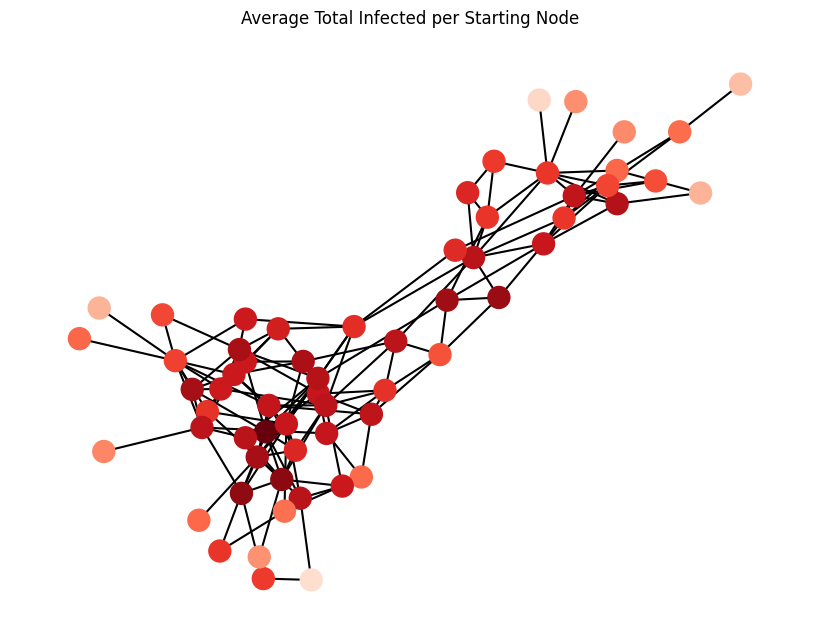

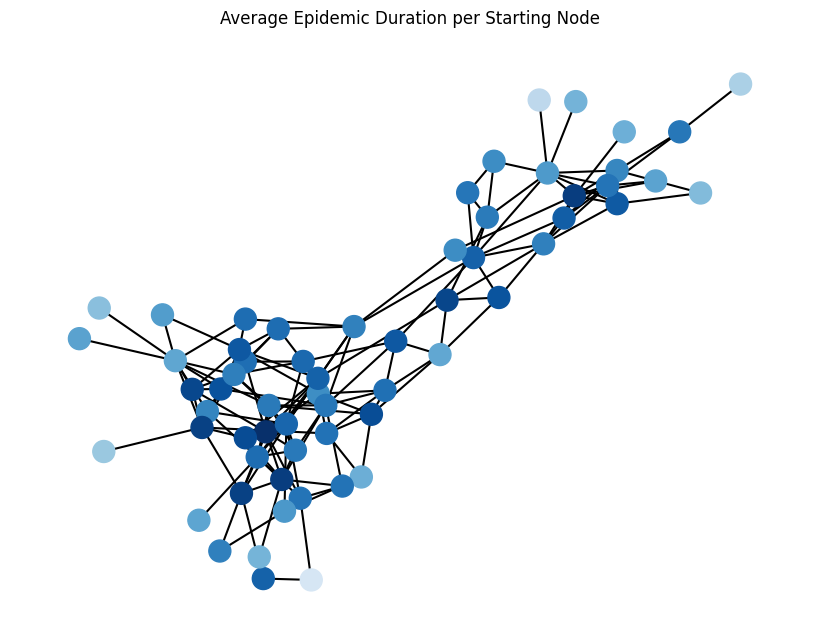

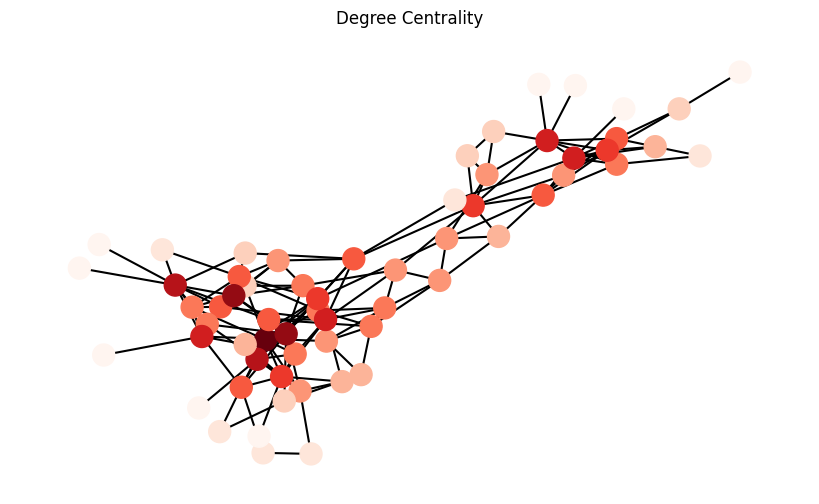

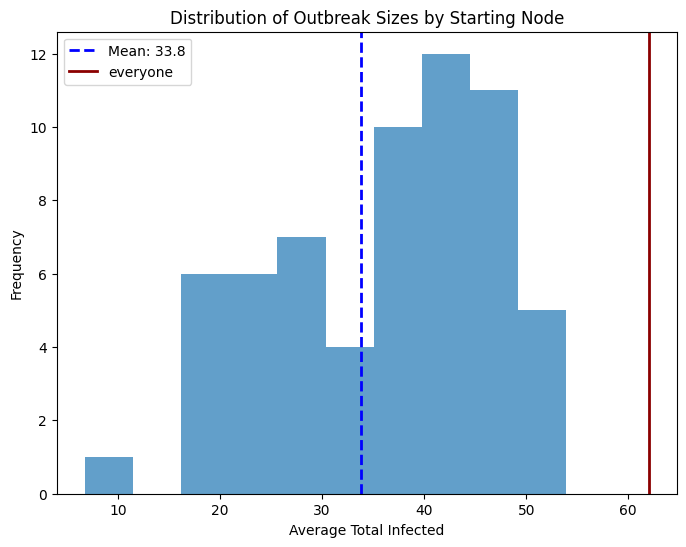

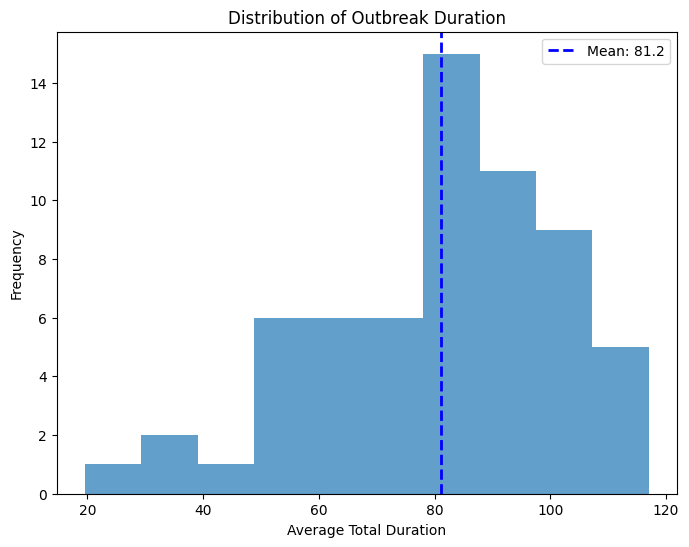

In [116]:
plt.figure(figsize=[8,6])
nx.draw(dolphin_graph_loaded,
        pos=pos,
        node_color=[avg_infected_per_node[x] for x in dolphin_graph_loaded.nodes()],
        width=1.5,
        cmap="Reds",
        node_shape='o',
        node_size=250,
        vmin=0,
        vmax=max([avg_infected_per_node[x] for x in dolphin_graph_loaded.nodes()]))
plt.title("Average Total Infected per Starting Node")
plt.show()


plt.figure(figsize=[8,6])
nx.draw(dolphin_graph_loaded,
        pos=pos,
        node_color=[avg_duration_per_node[x] for x in dolphin_graph_loaded.nodes()],
        width=1.5,
        cmap="Blues",
        node_shape='o',
        node_size=250,
        vmin=0,
        vmax=max([avg_duration_per_node[x] for x in dolphin_graph_loaded.nodes()]))
plt.title("Average Epidemic Duration per Starting Node")
plt.show()

plt.figure(figsize=[10.315,6])
nx.draw_networkx_nodes(dolphin_graph_loaded,
                                pos=pos,
                                node_color=[degree_centrality[x] for x in dolphin_graph_loaded.nodes()],
                                cmap="Reds",
                                node_size=250)
nx.draw_networkx_edges(dolphin_graph_loaded, pos=pos, width=1.5)
plt.title("Degree Centrality")
plt.axis('off')
plt.show()

plt.figure(figsize=[8,6])
plt.hist(avg_infected_values, alpha=0.7)
plt.axvline(np.mean(avg_infected_per_node), color='blue', linewidth=2, linestyle='--', label=f'Mean: {np.mean(avg_infected_per_node):.1f}')
plt.axvline(len(dolphin_graph_loaded.nodes()), color='darkred', linewidth=2, label='everyone')
plt.xlabel('Average Total Infected')
plt.ylabel('Frequency')
plt.title('Distribution of Outbreak Sizes by Starting Node')
plt.legend()
plt.show()

plt.figure(figsize=[8,6])
plt.hist(avg_duration_per_node, alpha=0.7)
plt.axvline(np.mean(avg_duration_per_node), color='blue', linewidth=2, linestyle='--', label=f'Mean: {np.mean(avg_duration_per_node):.1f}')
plt.xlabel('Average Total Duration')
plt.ylabel('Frequency')
plt.title('Distribution of Outbreak Duration')
plt.legend()
plt.show()

## Problem 3
#### Kindergarten Classroom Network

#### (A) For each of the classrooms compare the transitivities of 100 Erdos–Renyi networks with parameters chosen to match the corresponding classroom.

#### (B) Choose one of the classroom networks and consider the arrival of a new student to the class. Describe a randomized method for deciding who that student might choose to connect to in the classroom. Perform your procedure 100 times (add a node to the network and choose which other nodes to connect it to using your model). Compare the average statistics of the newly added node to the properties of the nodes already in the classroom. What do you observe? How confident are you that your model is reproducing the dynamics that formed the classroom network originally?

## Problem 4
#### Small Network

note: node 7 uniformly goes to any node it is connected to

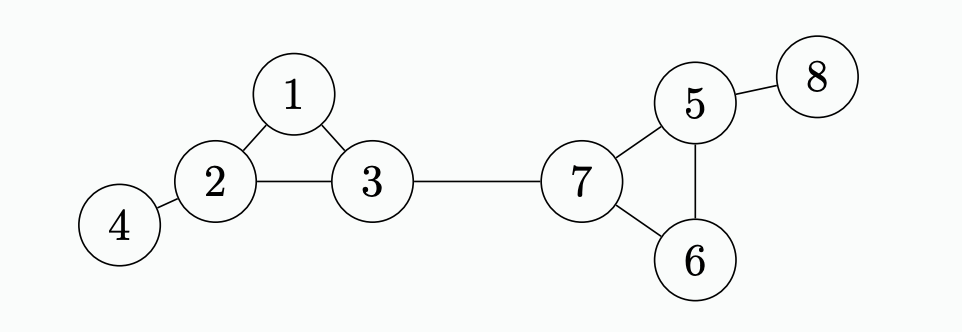